__Papermils parameters__

In [1]:
FILL     = 8142
wiresON  = True
SAVEPATH = '../Results_Lumi_V2/wires_on/'

---
---

# IMPORTS

In [2]:
INTERACTIVE = False
FIGWIDTH    = 12
SAVING      = False

# CHOOSE INTERACTIVE ON/OFF
if INTERACTIVE:
    %matplotlib widget
else:
    %matplotlib inline
#----------------------
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mpldates
import pandas as pd
import glob
import sys
sys.path.append('../')

import pynumdiff
import fillingpatterns as fp

# Make sure this import is after pandas
import Backend.ABPPandas

import Backend.Constants as cst
import Backend.NXCALS as nx


# Matplotlib config
for key in plt.rcParams.keys():
    if 'date.auto' in key:
        plt.rcParams[key] = "%H:%M"


# Creating NXCALS variable containers
wires     = {'B1': [nx.NXCALSWire(loc = loc) for loc in ['L1B1','L5B1']],
             'B2': [nx.NXCALSWire(loc = loc) for loc in ['R1B2','R5B2']]}
beams     = [nx.NXCALSBeam(name) for name in ['B1','B2']]

buckets   = np.arange(3564)



2022-09-14 11:53:45,400 [INFO] 
Limited Linear Model Support Detected! 
---> PYCHEBFUN is not installed. 
---> Install pychebfun to use chebfun derivatives (https://github.com/pychebfun/pychebfun/) 
You can still use other methods 



# Loading data

In [3]:
# Everything except BPMs
var_needed  = [_var for _var in beams[0]._getVarList() + beams[1]._getVarList()]
var_needed += [wire.I for wire in wires['B1']+wires['B2']]
var_needed += ['HX:BMODE','LHC.STATS:LHC:INJECTION_SCHEME']

var_needed = list(set(var_needed))

var_needed = [_var for _var in var_needed if ('BFC' not in _var)]
var_needed = [_var for _var in var_needed if ('BQBB' not in _var)]
var_needed.remove('ALICE:BUNCH_LUMI_INST')
var_needed.remove('LHCB:BUNCH_LUMI_INST')

tune_vars = ['LhcStateTracker:LHCBEAM1:QH_TRIM:value',
             'LhcStateTracker:LHCBEAM1:QV_TRIM:value',
             'LhcStateTracker:LHCBEAM2:QH_TRIM:value',
             'LhcStateTracker:LHCBEAM2:QV_TRIM:value']


# Locating data
DATA_PATH = '/eos/project/l/lhc-lumimod/LuminosityFollowUp/2022_test_v0.2.2/'


# Importing fill data
database = pd.read_parquet(DATA_PATH+f'HX:FILLN={FILL}',columns=var_needed+tune_vars)
database = database.sort_index()
database.index.name = 'unix'
database.insert(0,'Timestamp',database.index)
database.insert(1,'Time',1e-9*(database.index - database.index[0]))
database['Timestamp'] = database['Timestamp'].apply(lambda t: pd.Timestamp(t).tz_localize('UTC'))



## Filling

Computing collision schedules...
Done Beam 1
Done Beam 2


Text(0.5, 0, 'Bunch number')

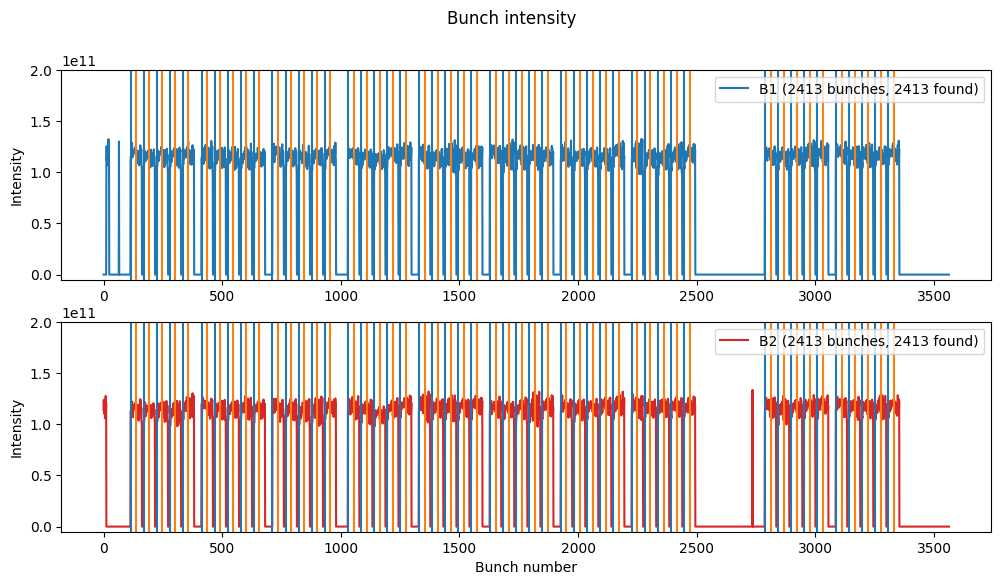

In [4]:


filled_buckets = {}
patterns       = {}
bunch_I        = {}
for beam in beams:
    
    filled_ts = np.min(database[database[beam['Intensity']]== np.max(database[beam['Intensity']])].index)
    
    sub = database.dropna(subset=[beam['Nb']])
    _ts = sub.index[sub.index.get_loc(filled_ts, method='nearest')]
    Nb        = int(database.loc[_ts,beam['Nb']])

    sub = database.dropna(subset=[beam['bb_Intensity']])
    _ts = sub.index[sub.index.get_loc(filled_ts, method='nearest')]
    
    
    bunch_I[beam.name]        =database.loc[_ts,beam['bb_Intensity']]
    filled_buckets[beam.name] = np.arange(len(buckets))[bunch_I[beam.name]!=0]
    patterns[beam.name]       = (bunch_I[beam.name]!=0)


# Figuring out filling patterns
patt = fp.FillingPattern(patterns['B1'], patterns['B2'])
patt.compute_beam_beam_schedule(n_lr_per_side=21)

for bb_patt in [patt.b1,patt.b2]:
    train_num     = np.repeat(np.arange(len(bb_patt.train_lengths)),bb_patt.train_lengths)
    train_lengths = np.repeat(bb_patt.train_lengths,bb_patt.train_lengths)
    bb_patt.bb_schedule.insert(0,'Train',train_num)
    bb_patt.bb_schedule.insert(1,'Train Lengths',train_lengths)
    bb_patt.bb_schedule.insert(2,'Tag',None)


    targetTrain = bb_patt.bb_schedule['Train Lengths'].max()

    grouped = bb_patt.bb_schedule.groupby('Train')
    for train in list(grouped.groups.keys()):
        if grouped.get_group(train)['Train Lengths'].max() == targetTrain:
            _first  = grouped.get_group(train).index[0]
            _middle = grouped.get_group(train).index[targetTrain//2]

            bb_patt.bb_schedule.loc[_first,'Tag']  = 'first'
            bb_patt.bb_schedule.loc[_middle,'Tag'] = 'middle'

fig, axes = plt.subplots(figsize= (FIGWIDTH,6),ncols=1, nrows=2,gridspec_kw={'height_ratios': [1, 1]})
for beam,bb_df,ax,color in zip(beams,[patt.b1.bb_schedule,patt.b2.bb_schedule],axes,['C0','C3']):

    Nb_found = np.sum(bunch_I[beam.name]>0.5e11)

    plt.sca(ax)
    plt.plot(bunch_I[beam.name],color=color,label = f'{beam.name} ({Nb} bunches, {Nb_found} found)')
    

    firsts  =  bb_df.groupby('Tag').get_group('first').index
    middles =  bb_df.groupby('Tag').get_group('middle').index

    for bunch in firsts:
        plt.axvline(bunch)
    for bunch in middles:
        plt.axvline(bunch,color='C1')

    plt.legend()
    plt.ylim([-0.05e11,2e11])
    plt.ylabel('Intensity')
fig.suptitle('Bunch intensity')
plt.xlabel('Bunch number')


# ROI (Luminosity on)

2022-08-19 00:20:31.499580+00:00 | 2022-08-19 04:06:25.766293+00:00


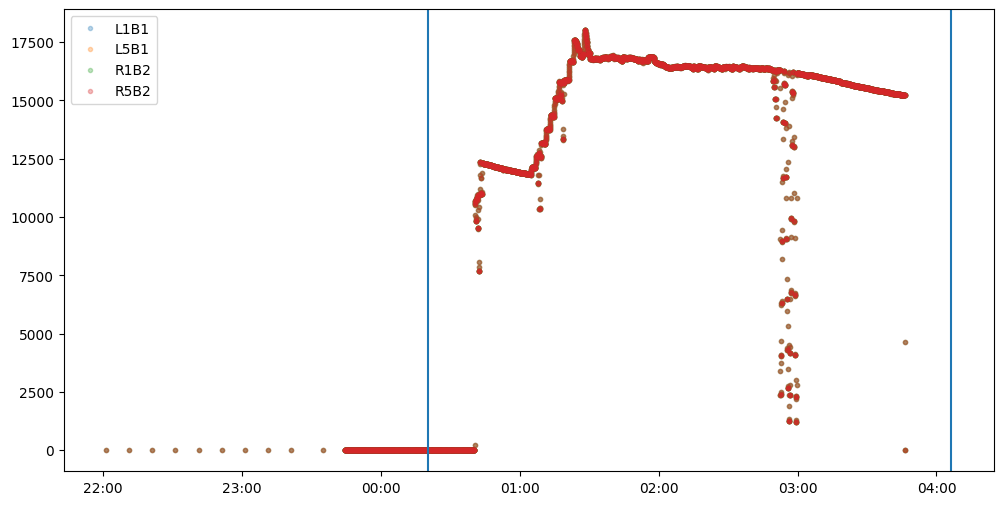

In [5]:
df = database.dropna(subset=[beams[0]['Luminosity']['ATLAS']])

start_ts = df[df[beams[0]['Luminosity']['ATLAS']]>1000]['Timestamp'].min()
stop_ts  = df[df[beams[0]['Luminosity']['ATLAS']]>1000]['Timestamp'].max()
start_time = df[df[beams[0]['Luminosity']['ATLAS']]>1000]['Time'].min()
stop_time  = df[df[beams[0]['Luminosity']['ATLAS']]>1000]['Time'].max()

if wiresON:
    df = database
    wire_start = df[df[wires['B1'][0]['I']]>10]['Timestamp'].min()
    wire_stop  = df[(df[wires['B1'][0]['I']]>295)&(df['Timestamp']>wire_start)]['Timestamp'].min()
    wire_start,wire_stop = wire_start-pd.Timedelta(minutes=3),wire_stop+pd.Timedelta(minutes=3)
else:
    wire_start,wire_stop = start_ts,stop_ts

start_ts,stop_ts = start_ts-pd.Timedelta(minutes=20),stop_ts+pd.Timedelta(minutes=20)
print(start_ts,'|',stop_ts)

plt.figure(figsize=(FIGWIDTH,6))
for wire in wires['B1']+wires['B2']:
    database.nxPlot('Timestamp',beams[0]['Luminosity']['ATLAS'],'.',alpha=0.3,label=wire.loc)
plt.axvline(start_ts)
plt.axvline(stop_ts)
plt.legend()

# COMPUTING lumi tot, Intensity AVG

In [6]:
from scipy.interpolate import interp1d

# COMPUTING LHCB BB-LUMI:
injection_scheme = database['LHC.STATS:LHC:INJECTION_SCHEME'].iloc[0]
nb_coll = {'ATLAS':int(injection_scheme.split('_')[2]),'CMS':int(injection_scheme.split('_')[2]),'LHCB':int(injection_scheme.split('_')[4]),'ALICE':int(injection_scheme.split('_')[3])}

nb_coll = {'ATLAS':len(buckets),'CMS':len(buckets),'LHCB':len(buckets),'ALICE':len(buckets)}

try:
    for loc in ['ALICE','LHCB']:    
        database.insert(5,f'{loc}:BUNCH_LUMI_INST',database[beams[0]['bb_Luminosity']['ATLAS']])

        times         = database[beams[0]['bb_Luminosity']['ATLAS']].dropna().index
        interp_values = np.interp(times, database[f'{loc}:LUMI_TOT_INST'].dropna().index ,database[f'{loc}:LUMI_TOT_INST'].dropna()/nb_coll[loc])
        #interp_values = 0*np.interp(times, database[f'{loc}:LUMI_TOT_INST'].dropna().index ,database[f'{loc}:LUMI_TOT_INST'].dropna()/nb_coll[loc])
        database.loc[times,f'{loc}:BUNCH_LUMI_INST'] = database[beams[0]['bb_Luminosity']['ATLAS']].dropna()*0 + interp_values
except:
    pass

# COMPUTING LUMI TOT
#============================
try:
    database.insert(4,'bb_LUMI_TOT',database[beams[0]['bb_Luminosity']['ATLAS']])
except:
    database['bb_LUMI_TOT'] = database[beams[0]['bb_Luminosity']['ATLAS']].copy()


times,lumi_tot  = database['bb_LUMI_TOT'].to_2D()
for loc in ['ALICE','CMS','LHCB']:
    times_found,allBunches = database[beams[0]['bb_Luminosity'][loc]].to_2D()

    lumi_tot   += interp1d(times_found,allBunches,axis=0)(times)

database.loc[times,'bb_LUMI_TOT'] = pd.DataFrame({'tmp':list(lumi_tot)},index=times)['tmp']

#============================


# Computing intensity avg (every 20 seconds)ç
def compute_BCT_avg(df):

    STABLE_start = df[df['HX:BMODE'] == 'STABLE']['Time'].iloc[0]

    # Computing intensity avg (every 20 seconds)
    binWind = 20

    _times   = df.set_index('Time')[beams[0]['bb_Luminosity']['ATLAS']].dropna().index
    bins    = np.arange(_times[0]+binWind/2,_times[-1],binWind)

    new_dict = {}
    for beam in beams:

        observable = beam['Intensity']
        #observable = beam['Intensity'].replace('A6','B6')
        times,ref  = df.bin(observable,bins=bins)[['Time',observable]].T.to_numpy()
        STABLE_idx = np.argmin(np.abs(times-STABLE_start))

        observable = beam['bb_Intensity']
        total_A    = df.bin(observable,bins=bins)[observable]
        calib_A   = np.mean((ref/total_A.apply(lambda line:np.sum(line)))[STABLE_idx:STABLE_idx+int(10*(60/binWind))])

        new_dict[f'bb_Intensity_A_{beam.name}'] = total_A*calib_A

        observable = beam['bb_Intensity_B']
        total_B    = df.bin(observable,bins=bins)[observable]
        calib_B   = np.mean((ref/total_B.apply(lambda line:np.sum(line)))[STABLE_idx:STABLE_idx+int(10*(60/binWind))])

        new_dict[f'bb_Intensity_B_{beam.name}']   = total_B*calib_B

        new_dict[f'bb_Intensity_avg_{beam.name}'] = (total_A*calib_A + total_B*calib_B)/2



    return pd.concat([  df.bin(beams[0]['Intensity'],bins=bins)[['unix','Timestamp','Time']],
                        pd.DataFrame(new_dict)],axis=1).set_index('unix')


BCT_avg  = compute_BCT_avg(database)
database = pd.concat([database,BCT_avg.drop(columns=['Timestamp','Time'])],axis=1)
database.loc[BCT_avg.index,'Time']      = BCT_avg['Time']
database.loc[BCT_avg.index,'Timestamp'] = BCT_avg['Timestamp']


# Computing Lifetime, x-section

In [7]:
def first_order_diff(x,dt):
    # Taken from
    # https://github.com/luckystarufo/PyNumDiff/blob/upgrade/pynumdiff/finite_difference/_finite_difference.py

    # Calculate the finite difference
    dxdt_hat = np.diff(x,axis=0) / dt
    
    # Pad the data
    dxdt_hat = np.vstack((dxdt_hat[0,:], dxdt_hat, dxdt_hat[-1,:]))
    
    # Re-finite dxdt_hat using linear interpolation
    dxdt_hat = np.mean((dxdt_hat[0:-1,:], dxdt_hat[1:,:]), axis=0)

    return dxdt_hat


def compute_lifetime_xsection(df,beam):

    #----------------------------------------
    # Luminosity is measured every minute, let's use it without too much manipulations
    tmp = df.set_index('Time')['bb_LUMI_TOT'].dropna().index
    
    # forcing constant time steps
    dt    = 60
    times = np.arange(tmp[0],tmp[-1],dt)
    bins  = np.diff(times)/2 + times[:-1]
    #-----------------------------------------

    # Extracting data
    #-----------------------------------------
    observable     = f'bb_Intensity_avg_{beam.name}'
    times_N,data_N = df.bin(observable,bins=bins).set_index('Time')[observable].dropna().to_2D()

    observable     = 'bb_LUMI_TOT'
    times_L,data_L = df.set_index('Time')[observable].dropna().to_2D()
    #----------------------------------------


    # Aligning times with interpolation
    #---------------------------------
    times   = times[10:-10]
    data_N  =     interp1d(times_N,data_N,axis=0)(times)
    data_L  = 1e6*interp1d(times_L,data_L,axis=0)(times)
    #---------------------------------

    # Computing xsection and lifetime
    #---------------------------------
    dNdt     = first_order_diff(data_N,dt)
    xsection = -dNdt/data_L
    lifetime = -data_N/dNdt
    #---------------------------------


    # UNPACKING RESULTS
    bin_unix      = (times - df.iloc[0]['Time'])*1e9 + df.index[0]
    bin_timestamp = [pd.Timestamp(t).tz_localize('UTC') for t in bin_unix]


    return pd.DataFrame({'Time':times,'Timestamp':bin_timestamp,'dNdt':list(dNdt),'Lifetime':list(lifetime),'sig_eff':list(xsection)},index=bin_unix)


def smooth_lifetime_xsection(df,beam):

    #----------------------------------------
    # Luminosity is measured every minute, let's use it without too much manipulations
    tmp = df.set_index('Time')['bb_LUMI_TOT'].dropna().index
    
    # forcing constant time steps
    dt    = 60
    times = np.arange(tmp[0],tmp[-1],dt)
    bins  = np.diff(times)/2 + times[:-1]
    #-----------------------------------------

    # Extracting data
    #-----------------------------------------
    observable     = f'bb_Intensity_avg_{beam.name}'
    times_N,data_N = df.set_index('Time')[observable].dropna().to_2D()
    dt_N           = np.mean(np.diff(times_N))



    observable     = 'bb_LUMI_TOT'
    times_L,data_L = df.set_index('Time')[observable].dropna().to_2D()
    #----------------------------------------

    # Computing dNdt
    params = [18,2]
    dNdt   = np.nan*data_N.copy()
    for bucket in buckets:
        N_hat,dNdt_hat  = pynumdiff.smooth_finite_difference.meandiff(data_N[:,bucket], dt_N, params, options={'iterate': True})
        dNdt[:,bucket]   = dNdt_hat
        data_N[:,bucket] = N_hat 


    # Aligning times with interpolation
    #---------------------------------
    times   = times[10:-10]
    data_N  =     interp1d(times_N,data_N,axis=0)(times)
    dNdt    =     interp1d(times_N,dNdt  ,axis=0)(times)
    data_L  = 1e6*interp1d(times_L,data_L,axis=0)(times)
    #---------------------------------

    # Computing xsection and lifetime
    #---------------------------------
    xsection = -dNdt/data_L
    lifetime = -data_N/dNdt
    #---------------------------------


    # UNPACKING RESULTS
    bin_unix      = (times - df.iloc[0]['Time'])*1e9 + df.index[0]
    bin_timestamp = [pd.Timestamp(t).tz_localize('UTC') for t in bin_unix]


    return pd.DataFrame({'Time':times,'Timestamp':bin_timestamp,'dNdt':list(dNdt),'Lifetime':list(lifetime),'sig_eff':list(xsection)},index=bin_unix)



xsection_df        = {}
xsection_smooth_df = {}
for beam in beams:
    xsection_df[beam.name]         = compute_lifetime_xsection(database,beam)
    xsection_smooth_df[beam.name]  =  smooth_lifetime_xsection(database,beam)

    if SAVING:
        xsection_df[beam.name].to_pickle(f"{SAVEPATH}/pickles/xsection_F{FILL}_{beam.name}.pkl")
        xsection_smooth_df[beam.name].to_pickle(f"{SAVEPATH}/pickles/xsection_smooth_F{FILL}_{beam.name}.pkl")

/home/phbelang/abp/WireDAQ/py_wireDAQ/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide
/home/phbelang/abp/WireDAQ/py_wireDAQ/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in true_divide


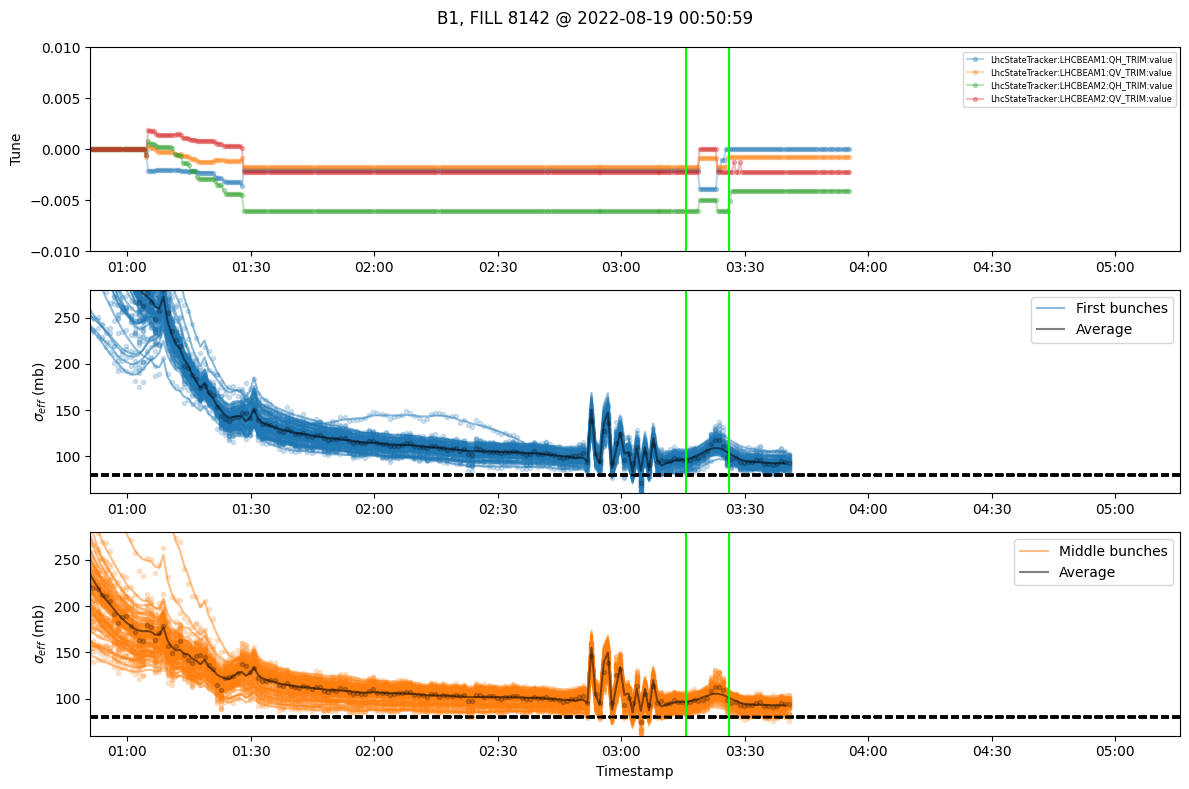

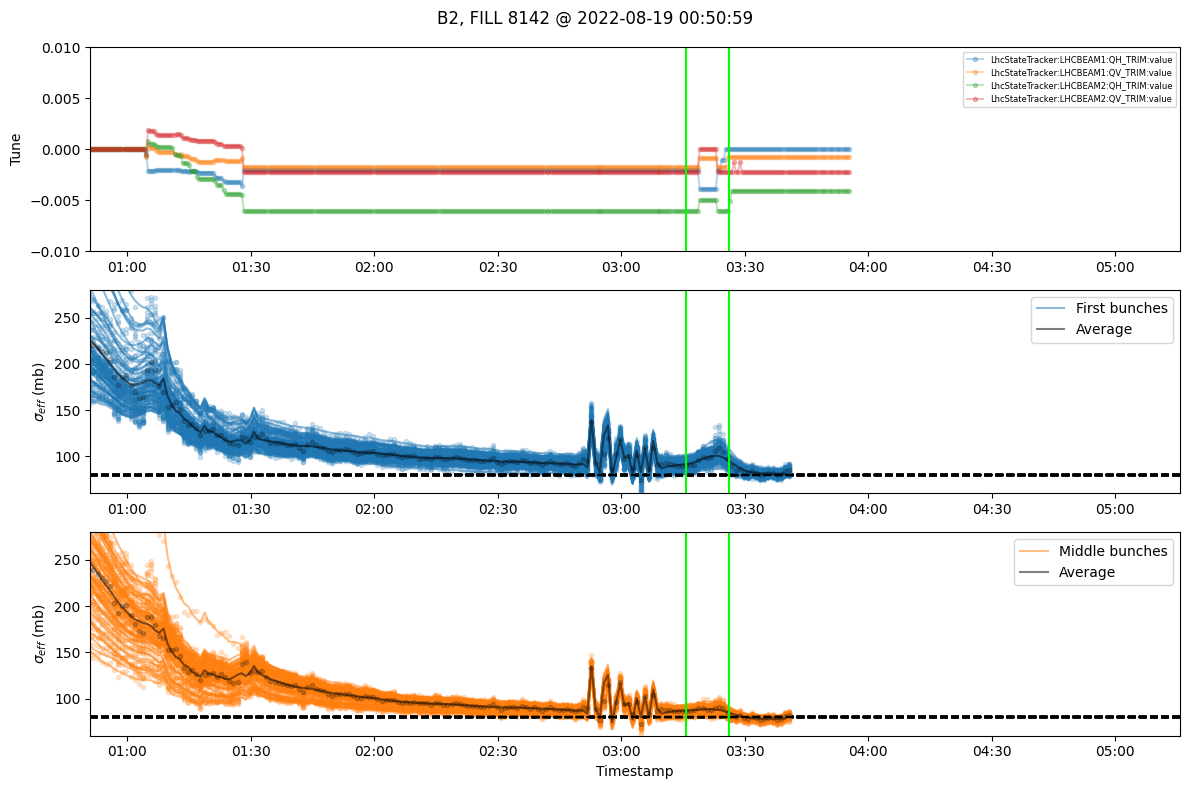

In [8]:


#------------------------------------------

start_ts = database[database['HX:BMODE'] == 'STABLE']['Timestamp'].iloc[0]
stop_ts  = wire_start+pd.Timedelta(hours=2)

def Make_Fig(figsize= (FIGWIDTH,8)):
    fig, _axes = plt.subplots(figsize=figsize,ncols=1, nrows=3,gridspec_kw={'height_ratios': [1,1, 1]})

    axes = {'tune'   :_axes[0],
            'first'  :_axes[1],
			'middle' :_axes[2]}


    return fig,axes
#------------------------------------------



plt.close('all')


for beam,bb_df in zip(beams,[patt.b1.bb_schedule,patt.b2.bb_schedule]):

    

    fig,axes = Make_Fig()
    plt.suptitle(f'{beam.name}, FILL {FILL} @ {str(start_ts)[:19]}')

    # TUNES
    #---------------------------
    plt.sca(axes['tune'])
    for ii in tune_vars:

        time = database.set_index('Timestamp')[ii].dropna().index[0:-1:1000]
        data = database[ii].dropna().iloc[0:-1:1000]
        ref = database.at_ts(start_ts ,ii,method='nearest',return_ts=False)
        
        plt.plot(time,data-ref,'.-',alpha=0.3,label=ii)
     

    plt.ylim([-1e-2,1e-2])
    plt.legend(fontsize=6,loc='best')
    plt.ylabel('Tune')
    #---------------------------

    
    firsts  =  bb_df.groupby('Tag').get_group('first').index
    middles =  bb_df.groupby('Tag').get_group('middle').index

    for tagged,info,color in zip([firsts,middles],['first','middle'],['C0','C1']):    
        for bunch in tagged:

            ts       = xsection_df[beam.name]['Timestamp']
            xsection = xsection_df[beam.name]['sig_eff'].apply(lambda line:line[bunch])
            lifetime = xsection_df[beam.name]['Lifetime'].apply(lambda line:line[bunch])

            ts_smooth       = xsection_smooth_df[beam.name]['Timestamp']
            xsection_smooth = xsection_smooth_df[beam.name]['sig_eff'].apply(lambda line:line[bunch])
            lifetime_smooth     = xsection_smooth_df[beam.name]['Lifetime'].apply(lambda line:line[bunch])


            plt.sca(axes[info])
            plt.plot(ts       ,xsection/1e-3       ,'.',alpha=0.2,color=color)
            plt.plot(ts_smooth,xsection_smooth/1e-3,'-',alpha=0.5,color=color)
            plt.axhline(80,ls='--',color='k')
            plt.ylim([60,280])
            plt.ylabel(r'$\sigma_{eff}$ (mb)')

        # Computing avg

        ts              = xsection_df[beam.name]['Timestamp']
        xsection        = xsection_df[beam.name]['sig_eff'].apply(lambda line:np.mean(line[tagged]))
        xsection_smooth = xsection_smooth_df[beam.name]['sig_eff'].apply(lambda line:np.mean(line[tagged]))
        plt.sca(axes[info])
        plt.plot(ts       ,xsection/1e-3       ,'.',alpha=0.2,color='k')
        plt.plot(ts_smooth,xsection_smooth/1e-3,'-',alpha=0.5,color='k')



    for ax in axes.values():
        plt.sca(ax)
        plt.axvline(wire_start,color='lime')
        plt.axvline(wire_stop,color='lime')
        plt.xlim([start_ts,stop_ts])

    plt.xlabel('Timestamp')

    plt.sca(axes['first'])
    plt.plot([np.nan],[np.nan],color='C0',alpha=0.5,label = 'First bunches')
    plt.plot([np.nan],[np.nan],color='k' ,alpha=0.5,label = 'Average')
    plt.legend()

    plt.sca(axes['middle'])
    plt.plot([np.nan],[np.nan],color='C1',alpha=0.5,label = 'Middle bunches')
    plt.plot([np.nan],[np.nan],color='k' ,alpha=0.5,label = 'Average')
    plt.legend()
    plt.tight_layout()

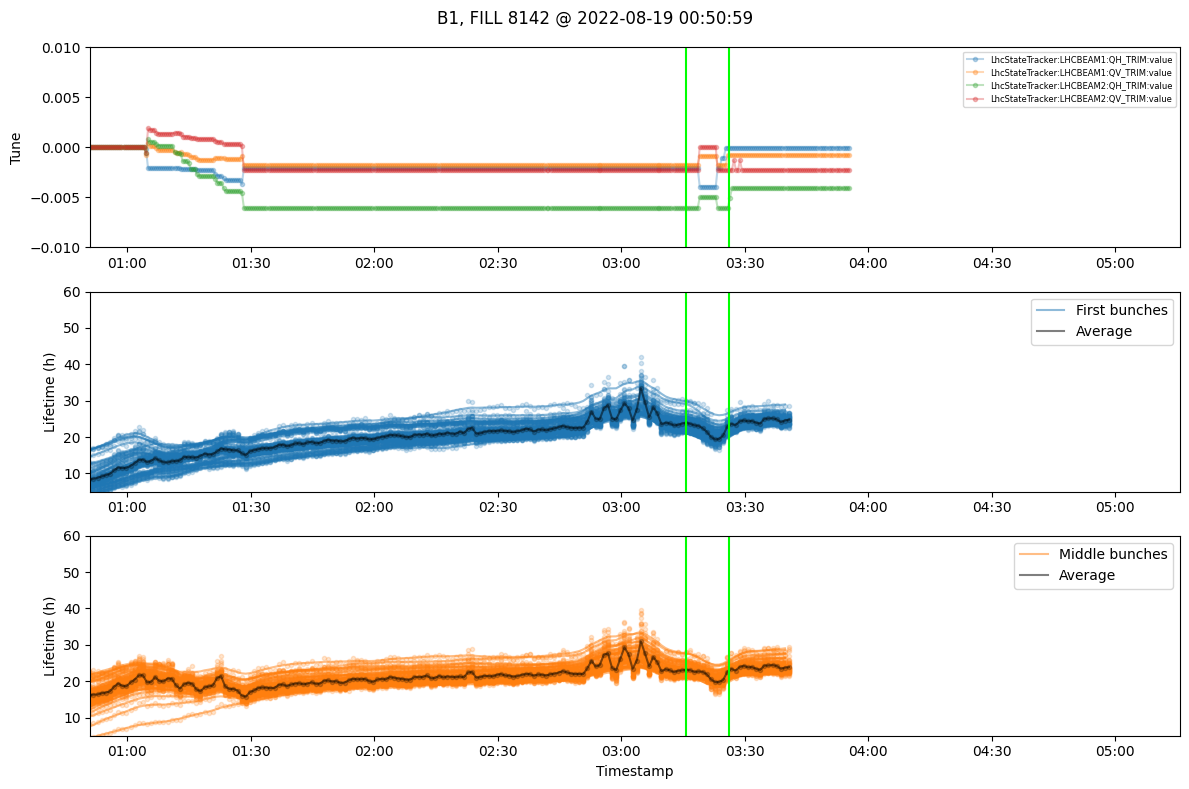

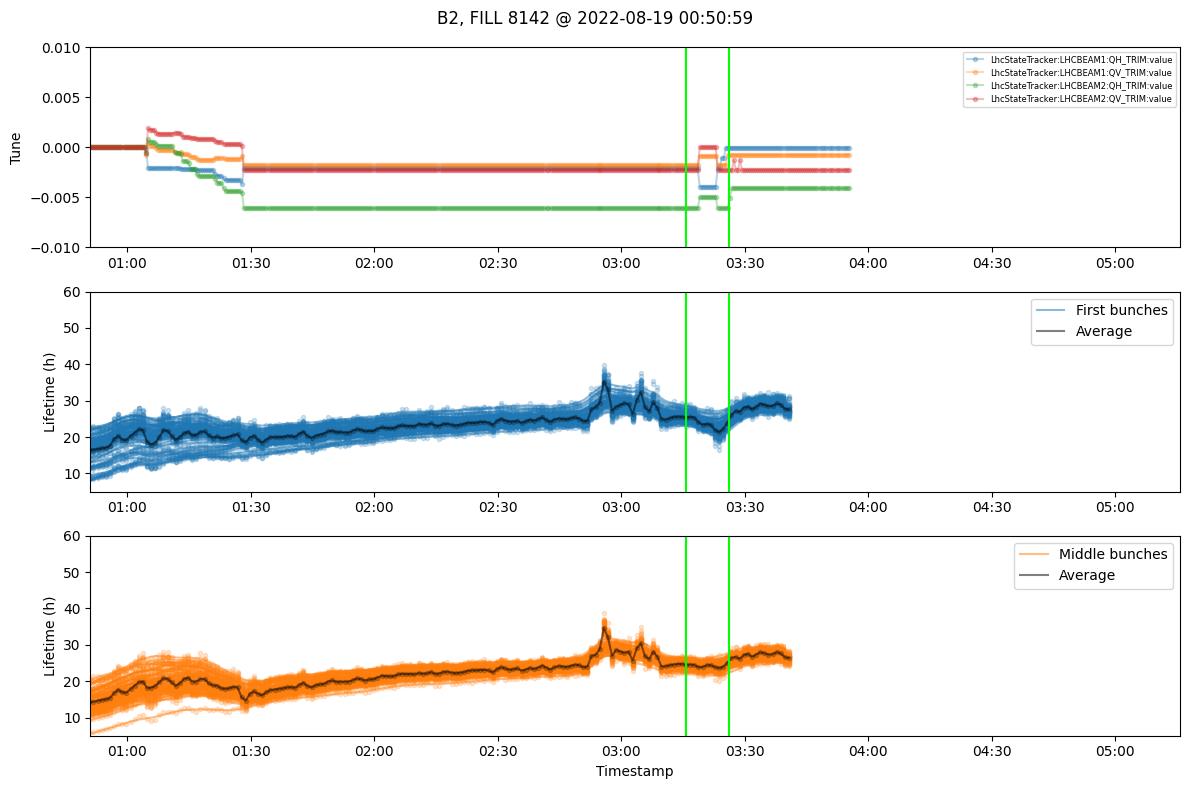

In [9]:


#------------------------------------------

start_ts = database[database['HX:BMODE'] == 'STABLE']['Timestamp'].iloc[0]
stop_ts  = wire_start+pd.Timedelta(hours=2)

def Make_Fig(figsize= (FIGWIDTH,8)):
    fig, _axes = plt.subplots(figsize=figsize,ncols=1, nrows=3,gridspec_kw={'height_ratios': [1,1, 1]})

    axes = {'tune'   :_axes[0],
            'first'  :_axes[1],
			'middle' :_axes[2]}


    return fig,axes
#------------------------------------------



plt.close('all')


for beam,bb_df in zip(beams,[patt.b1.bb_schedule,patt.b2.bb_schedule]):

    

    fig,axes = Make_Fig()
    plt.suptitle(f'{beam.name}, FILL {FILL} @ {str(start_ts)[:19]}')

    # TUNES
    #---------------------------
    plt.sca(axes['tune'])
    for ii in tune_vars:

        time = database.set_index('Timestamp')[ii].dropna().index[0:-1:1000]
        data = database[ii].dropna().iloc[0:-1:1000]
        ref = database.at_ts(start_ts ,ii,method='nearest',return_ts=False)
        
        plt.plot(time,data-ref,'.-',alpha=0.3,label=ii)
     

    plt.ylim([-1e-2,1e-2])
    plt.legend(fontsize=6,loc='best')
    plt.ylabel('Tune')
    #---------------------------

    
    firsts  =  bb_df.groupby('Tag').get_group('first').index
    middles =  bb_df.groupby('Tag').get_group('middle').index

    for tagged,info,color in zip([firsts,middles],['first','middle'],['C0','C1']):    
        for bunch in tagged:

            ts       = xsection_df[beam.name]['Timestamp']
            lifetime = xsection_df[beam.name]['Lifetime'].apply(lambda line:line[bunch])

            ts_smooth       = xsection_smooth_df[beam.name]['Timestamp']
            lifetime_smooth     = xsection_smooth_df[beam.name]['Lifetime'].apply(lambda line:line[bunch])


            plt.sca(axes[info])
            plt.plot(ts       ,lifetime/3600       ,'.',alpha=0.2,color=color)
            plt.plot(ts_smooth,lifetime_smooth/3600,'-',alpha=0.5,color=color)
            plt.axhline(80,ls='--',color='k')
            plt.ylim([5,60])
            plt.ylabel(r'Lifetime (h)')

        # Computing avg

        ts              = xsection_df[beam.name]['Timestamp']
        lifetime        = xsection_df[beam.name]['Lifetime'].apply(lambda line:np.mean(line[tagged]))
        lifetime_smooth = xsection_df[beam.name]['Lifetime'].apply(lambda line:np.mean(line[tagged]))
        plt.sca(axes[info])
        plt.plot(ts       ,lifetime/3600       ,'.',alpha=0.2,color='k')
        plt.plot(ts_smooth,lifetime_smooth/3600,'-',alpha=0.5,color='k')



    for ax in axes.values():
        plt.sca(ax)
        plt.axvline(wire_start,color='lime')
        plt.axvline(wire_stop,color='lime')
        plt.xlim([start_ts,stop_ts])

    plt.xlabel('Timestamp')

    plt.sca(axes['first'])
    plt.plot([np.nan],[np.nan],color='C0',alpha=0.5,label = 'First bunches')
    plt.plot([np.nan],[np.nan],color='k' ,alpha=0.5,label = 'Average')
    plt.legend()

    plt.sca(axes['middle'])
    plt.plot([np.nan],[np.nan],color='C1',alpha=0.5,label = 'Middle bunches')
    plt.plot([np.nan],[np.nan],color='k' ,alpha=0.5,label = 'Average')
    plt.legend()
    plt.tight_layout()

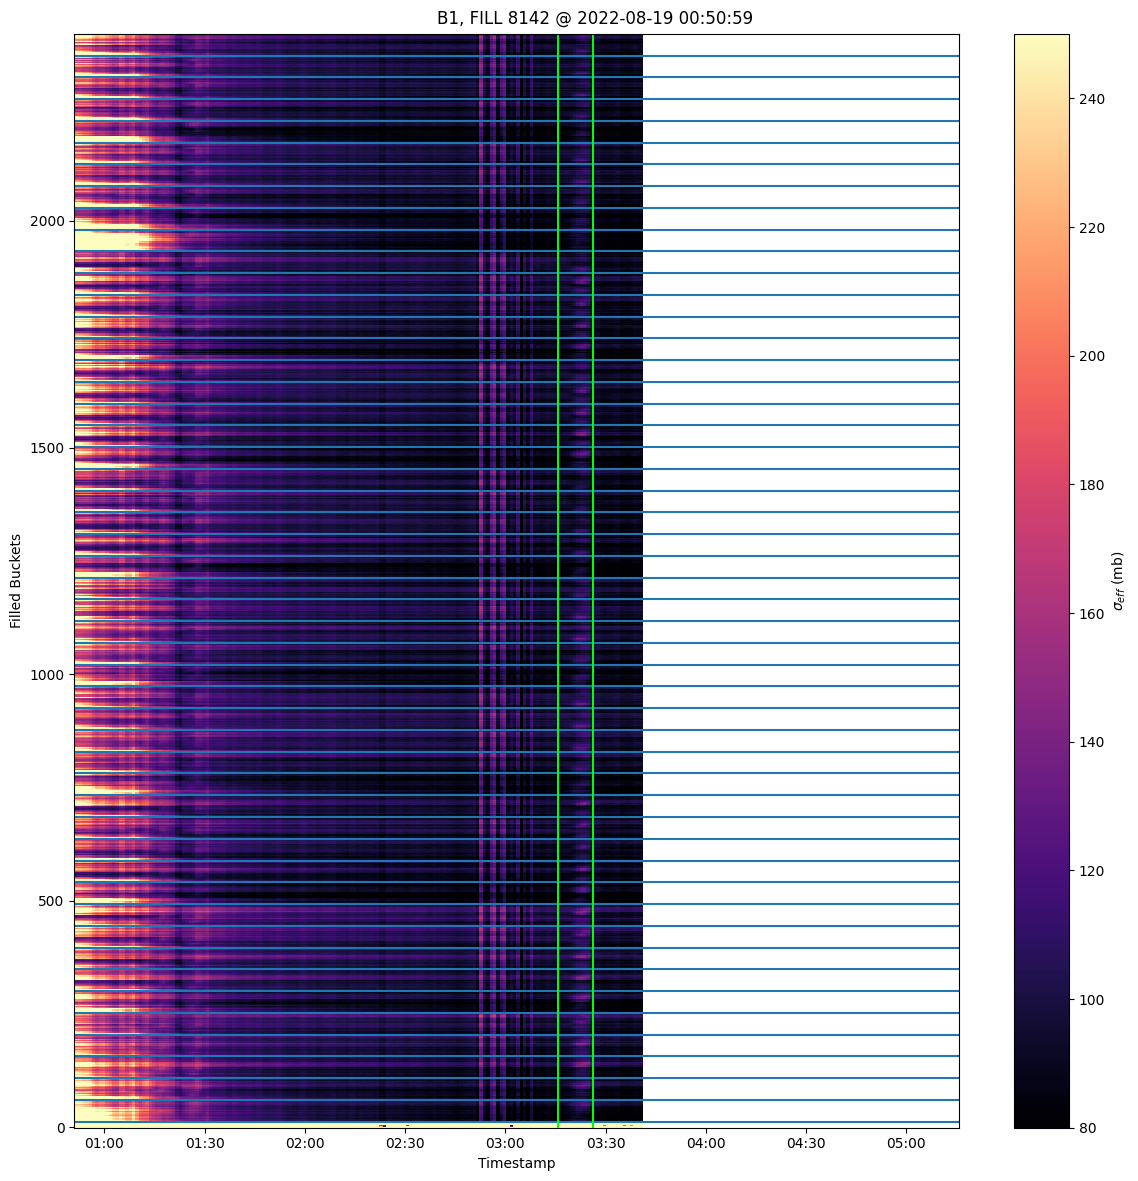

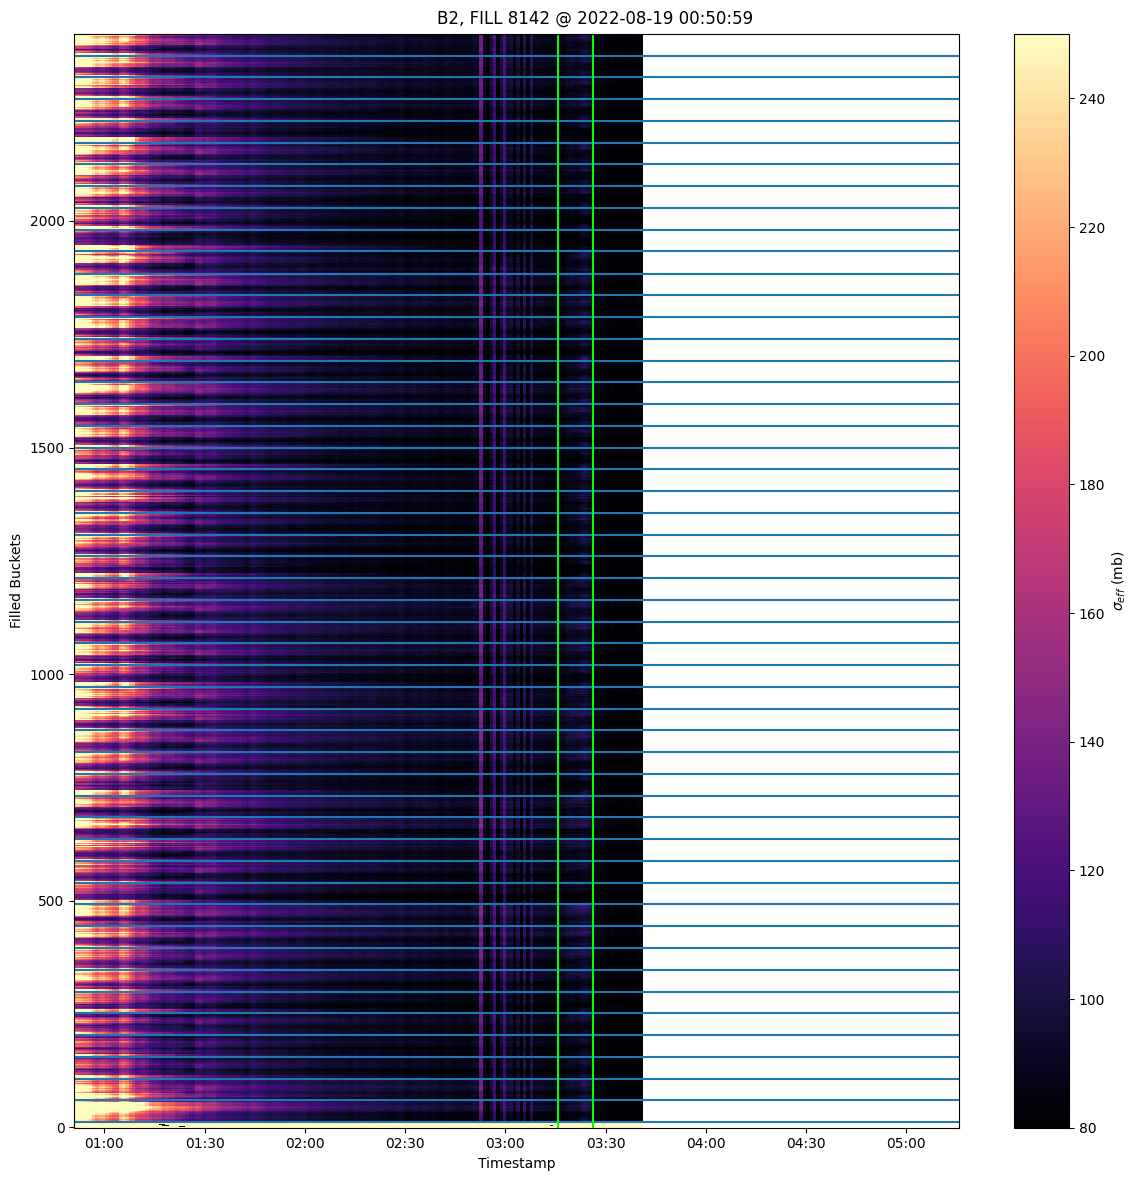

In [10]:

vmin = 80
vmax = 250

for beam,bb_df in zip(beams,[patt.b1.bb_schedule,patt.b2.bb_schedule]):
    fig = plt.figure(figsize=(FIGWIDTH,12))
    plt.suptitle(f'{beam.name}, FILL {FILL} @ {str(start_ts)[:19]}')
    
    results = xsection_df[beam.name]
    times,datagrid = results.set_index('Timestamp')['sig_eff'].to_2D()
    datagrid = datagrid[:,filled_buckets[beam.name]]
    
    firsts = bb_df.reset_index().groupby('Tag').get_group('first').index

    plt.pcolormesh(times, np.arange(np.shape(datagrid)[1]), datagrid.T/1e-3,vmin=vmin,vmax=vmax,cmap='magma')
    for bunch in firsts:
        plt.axhline(bunch,ls='-',color='C0')

    plt.axvline(wire_start,color='lime')
    plt.axvline(wire_stop,color='lime')

    cbar = plt.colorbar()
    cbar.set_label(r'$\sigma_{eff}$ (mb)')
    plt.ylabel('Filled Buckets')
    plt.xlabel('Timestamp')
    plt.xlim([start_ts,stop_ts])
    plt.tight_layout()
    

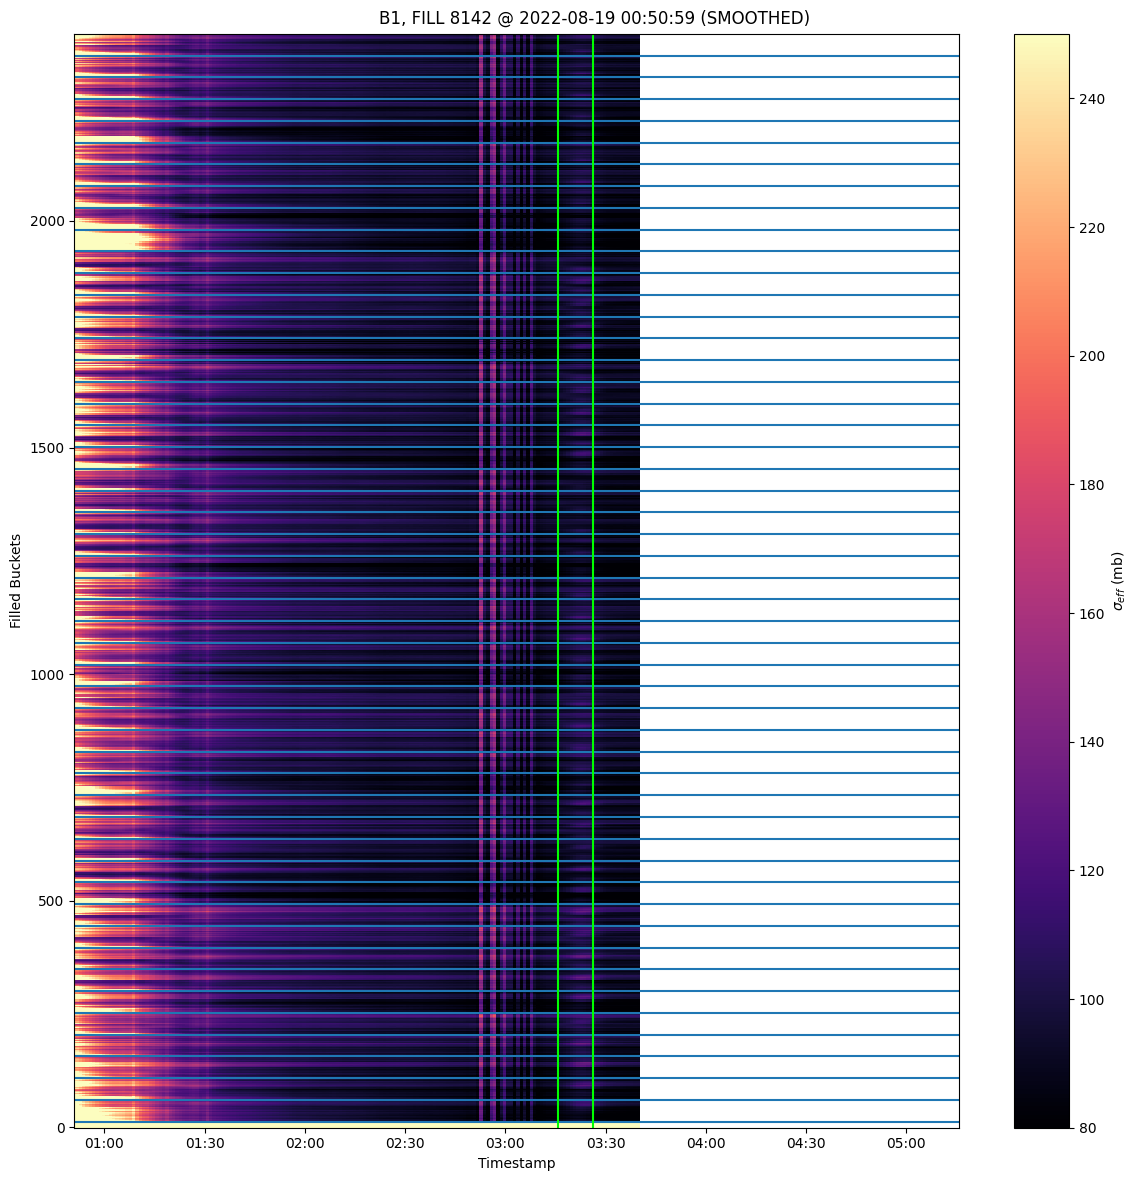

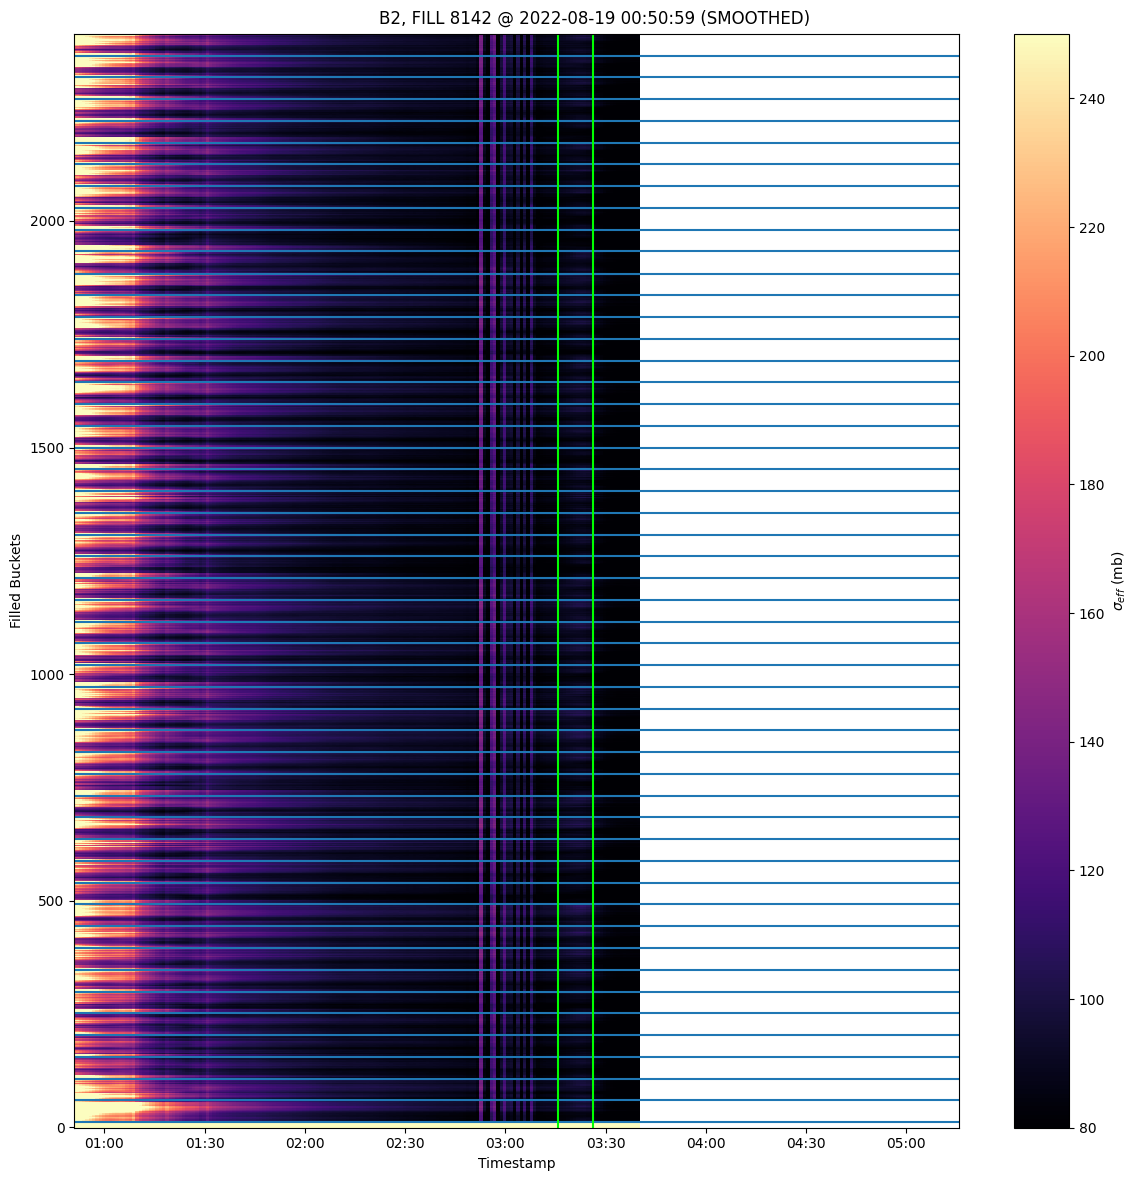

In [11]:

vmin = 80
vmax = 250

for beam,bb_df in zip(beams,[patt.b1.bb_schedule,patt.b2.bb_schedule]):
    fig = plt.figure(figsize=(FIGWIDTH,12))
    plt.suptitle(f'{beam.name}, FILL {FILL} @ {str(start_ts)[:19]} (SMOOTHED)')
    
    results = xsection_smooth_df[beam.name]
    times,datagrid = results.set_index('Timestamp')['sig_eff'].to_2D()
    datagrid = datagrid[:,filled_buckets[beam.name]]
    
    firsts = bb_df.reset_index().groupby('Tag').get_group('first').index

    plt.pcolormesh(times, np.arange(np.shape(datagrid)[1]), datagrid.T/1e-3,vmin=vmin,vmax=vmax,cmap='magma')
    for bunch in firsts:
        plt.axhline(bunch,ls='-',color='C0')

    plt.axvline(wire_start,color='lime')
    plt.axvline(wire_stop,color='lime')

    cbar = plt.colorbar()
    cbar.set_label(r'$\sigma_{eff}$ (mb)')
    plt.ylabel('Filled Buckets')
    plt.xlabel('Timestamp')
    plt.xlim([start_ts,stop_ts])
    plt.tight_layout()
    

# Exponential fit?

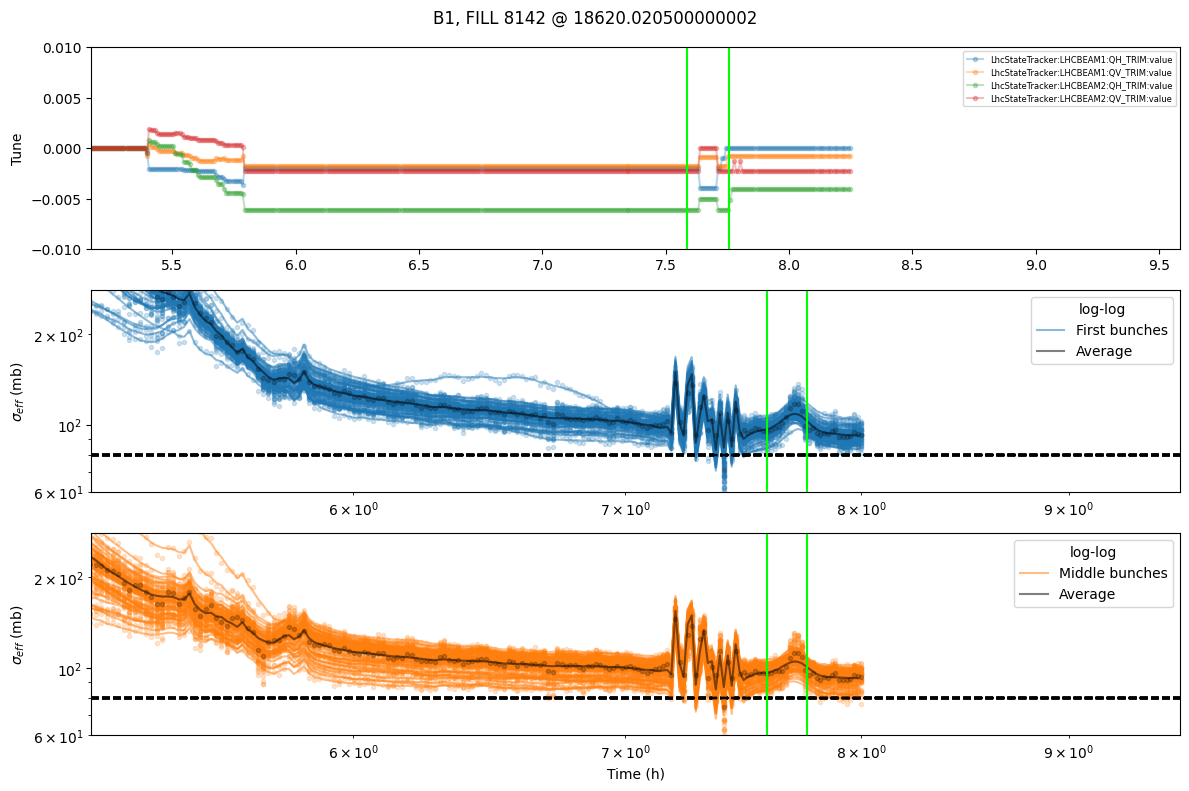

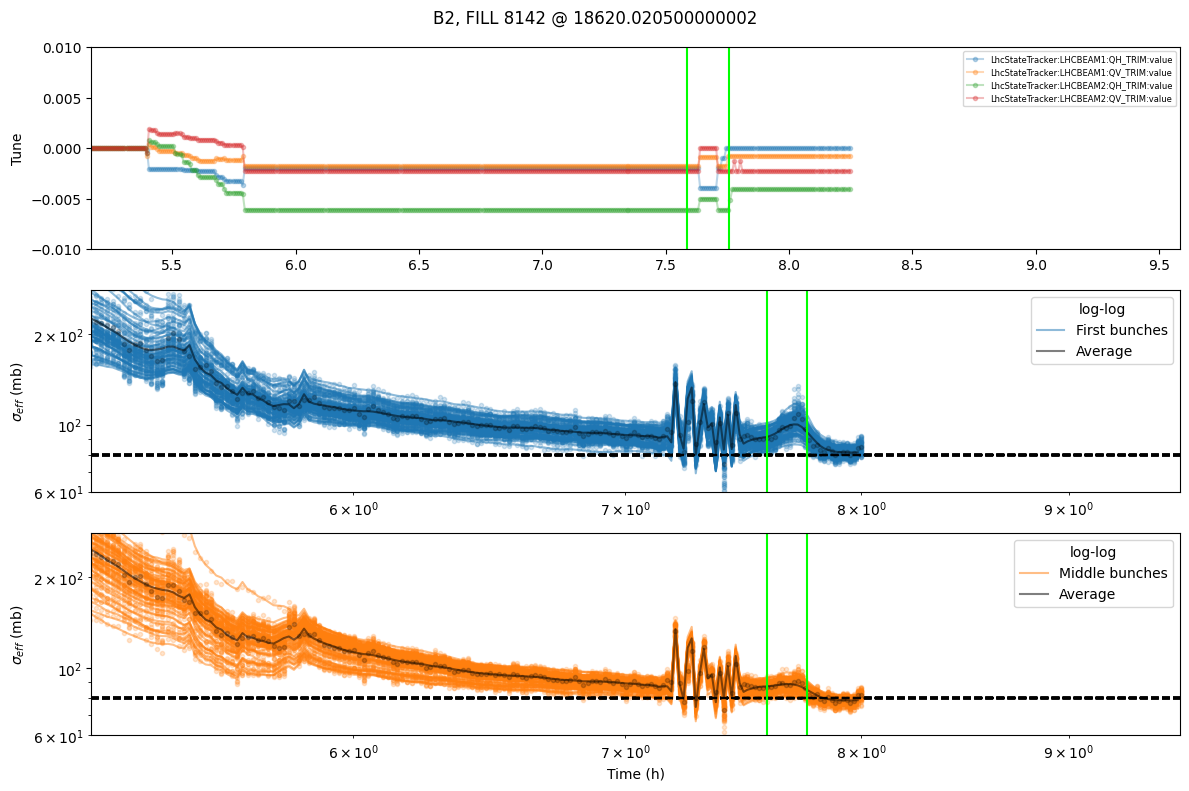

In [25]:

#def expfit()



#------------------------------------------

start_ts = database[database['HX:BMODE'] == 'STABLE']['Time'].iloc[0]
stop_ts  = start_ts+4*3600

def Make_Fig(figsize= (FIGWIDTH,8)):
    fig, _axes = plt.subplots(figsize=figsize,ncols=1, nrows=3,gridspec_kw={'height_ratios': [1,1, 1]})

    axes = {'tune'   :_axes[0],
            'first'  :_axes[1],
			'middle' :_axes[2]}


    return fig,axes
#------------------------------------------

if wiresON:
    df = database
    wire_start = df[df[wires['B1'][0]['I']]>10]['Time'].min()
    wire_stop  = df[(df[wires['B1'][0]['I']]>295)&(df['Time']>wire_start)]['Time'].min()
    wire_start,wire_stop = wire_start-3*60,wire_stop+3*60
    
start_ts = database[database['HX:BMODE'] == 'STABLE']['Time'].iloc[0]
stop_ts  = wire_start+2*3600
plt.close('all')


for beam,bb_df in zip(beams,[patt.b1.bb_schedule,patt.b2.bb_schedule]):

    

    fig,axes = Make_Fig()
    plt.suptitle(f'{beam.name}, FILL {FILL} @ {str(start_ts)[:19]}')

    # TUNES
    #---------------------------
    plt.sca(axes['tune'])
    for ii in tune_vars:

        time = database.set_index('Time')[ii].dropna().index[0:-1:1000]/3600
        data = database[ii].dropna().iloc[0:-1:1000]
        ref = database.at_ts(database[database['HX:BMODE'] == 'STABLE']['Timestamp'].iloc[0] ,ii,method='nearest',return_ts=False)
        
        plt.plot(time,data-ref,'.-',alpha=0.3,label=ii)
     

    plt.ylim([-1e-2,1e-2])
    plt.legend(fontsize=6,loc='best')
    plt.ylabel('Tune')
    #---------------------------

    
    firsts  =  bb_df.groupby('Tag').get_group('first').index
    middles =  bb_df.groupby('Tag').get_group('middle').index

    for tagged,info,color in zip([firsts,middles],['first','middle'],['C0','C1']):    
        for bunch in tagged:

            ts       = xsection_df[beam.name]['Time']/3600
            xsection = xsection_df[beam.name]['sig_eff'].apply(lambda line:line[bunch])
            lifetime = xsection_df[beam.name]['Lifetime'].apply(lambda line:line[bunch])

            ts_smooth       = xsection_smooth_df[beam.name]['Time']/3600
            xsection_smooth = xsection_smooth_df[beam.name]['sig_eff'].apply(lambda line:line[bunch])
            lifetime_smooth     = xsection_smooth_df[beam.name]['Lifetime'].apply(lambda line:line[bunch])


            plt.sca(axes[info])
            plt.plot(ts       ,xsection/1e-3       ,'.',alpha=0.2,color=color)
            plt.plot(ts_smooth,xsection_smooth/1e-3,'-',alpha=0.5,color=color)
            plt.axhline(80,ls='--',color='k')
            plt.ylim([60,280])
            plt.ylabel(r'$\sigma_{eff}$ (mb)')

        # Computing avg

        ts              = xsection_df[beam.name]['Time']/3600
        xsection        = xsection_df[beam.name]['sig_eff'].apply(lambda line:np.mean(line[tagged]))
        xsection_smooth = xsection_smooth_df[beam.name]['sig_eff'].apply(lambda line:np.mean(line[tagged]))
        plt.sca(axes[info])
        plt.plot(ts       ,xsection/1e-3       ,'.',alpha=0.2,color='k')
        plt.plot(ts_smooth,xsection_smooth/1e-3,'-',alpha=0.5,color='k')



    for ax in axes.values():
        plt.sca(ax)
        plt.axvline(wire_start/3600,color='lime')
        plt.axvline(wire_stop/3600,color='lime')
        plt.xlim([start_ts/3600,stop_ts/3600])

    plt.xlabel('Time (h)')

    plt.sca(axes['first'])
    plt.plot([np.nan],[np.nan],color='C0',alpha=0.5,label = 'First bunches')
    plt.plot([np.nan],[np.nan],color='k' ,alpha=0.5,label = 'Average')
    plt.legend(title='log-log')
    plt.yscale("log")
    plt.xscale("log")

    plt.sca(axes['middle'])
    plt.plot([np.nan],[np.nan],color='C1',alpha=0.5,label = 'Middle bunches')
    plt.plot([np.nan],[np.nan],color='k' ,alpha=0.5,label = 'Average')
    plt.legend(title='log-log')
    plt.tight_layout()
    plt.yscale("log")
    plt.xscale("log")
